In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import skellam
import matplotlib.pyplot as plt

In [2]:
#Create a Dataframe with 4 season
Data10=pd.read_csv("../Data/2009-2010.csv")
Data9=pd.read_csv("../Data/2008-2009.csv")
Data8=pd.read_csv("../Data/2007-2008.csv")
Data7=pd.read_csv("../Data/2006-2007.csv")
Data=pd.concat([Data7,Data8,Data9,Data10],sort=False,ignore_index=True)
Data=Data[['HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
Data.columns=['Home','Away','HG','AG','Result']
Out=["Lecce","Messina","Ascoli","Reggina","Empoli","Torino"]
for out in Out:
    Data = Data.loc[Data.Home != out]
    Data = Data.loc[Data.Away != out]
Data=Data.reset_index()
Team=Data.Home.value_counts().index
Data['diff_score']=Data['HG']-Data['AG']


In [16]:
#Create a dataframe with the coefficients to update
coef=pd.DataFrame({'Team':Team})
coef['Att']=np.random.normal(0,0.01,len(coef))
coef['Dif']=np.random.normal(0,0.01,len(coef))
coef.iloc[0]['Att']=coef.iloc[0]['Att'] -sum(coef['Att'].values)
coef.iloc[0]['Dif']=coef.iloc[0]['Dif'] -sum(coef['Dif'].values)
#In order to have identifiability of the covariates 
coef=coef.set_index('Team').sort_index()

delta = np.random.normal(0,0.01)
coef

C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Att,Dif
Team,,
Atalanta,-0.001435,-0.004281
Bari,-0.009771,0.000635
Bologna,0.008731,0.008397
Cagliari,-0.003481,-0.003287
Catania,0.013003,-0.021033
Chievo,-0.004078,-0.010901
Fiorentina,-0.023204,-0.010073
Genoa,-0.008123,-0.000862
Inter,-0.017743,0.022230


In [17]:
#Function to calculate the means for the Poisson distribution
def score_coef(att,dif,delta,Data):
    mu1=np.array([])
    mu2=np.array([])
    for i in Data.index:
        m1=np.exp(delta+att.loc[Data.loc[i].Home]-dif.loc[Data.loc[i].Away])
        m2=np.exp(att.loc[Data.loc[i].Away]-dif.loc[Data.loc[i].Home])
        mu1=np.append(mu1,m1)
        mu2=np.append(mu2,m2)
    return mu1, mu2

In [5]:
def log_prior (coef_att,coef_dif,delta):
    e= norm.logpdf(delta, loc=0, scale=0.1)
    for i in range(len(coef_att)):
        e=+ norm.logpdf(coef_att[i], loc=0, scale=0.1)+ norm.logpdf(coef_dif[i], loc=0, scale=0.01)
    return e

In [6]:
#Skellam log-likelihood
def log_skellam(mu1,mu2,score):
    D=0
    for i in range(len(score)):
        D+=skellam.logpmf(score.iloc[i], mu1.iloc[i], mu2.iloc[i], loc=0)
    return D

In [7]:
#log of unormalised distr
def log_tot (X):
    coef_att=np.concatenate(([-sum(X[1:20])],X[1:20]))
    coef_def=np.concatenate(([-sum(X[20:])],X[20:]))
    H=X[0]
    N=log_prior(coef_att,coef_def,H)
    coef['i1']=coef_att
    coef['i2']=coef_def
    L1,L2=score_coef(coef['i1'],coef['i2'],H,Data)
    Data['j1']=L1
    Data['j2']=L2
    N+=log_skellam(Data['j1'],Data['j2'],Data['diff_score'])
    return N  

In [8]:
#h(theta_n|theta_prop) for the acceptance ratio
def qprop(X,Y,tau,grad_x,grad_y):
    dif=X-Y
    c=-1/(4*tau)
    norm1=c*np.linalg.norm(-dif-np.multiply(tau,grad_x))**2
    norm2=c*np.linalg.norm(dif-np.multiply(tau,grad_y))**2
    return norm1-norm2


In [9]:
#Approximate th gradient using finite differences 
def grad(X,dx=0.01):
    grad=[]
    X_1=np.copy(X)
    X_2=np.copy(X)
    for i in range(len(X)):
        X_1[i]+=dx
        X_2[i]-=dx
        grad=np.concatenate((grad,[(log_tot(X_1)-log_tot(X_2))/(2*dx)]))
        X_1[i]-=dx
        X_2[i]+=dx
    return grad

    

In [10]:
mu1, mu2=score_coef(coef['Att'],coef['Dif'],delta,Data)
Data['mu1']=mu1
Data['mu2']=mu2


In [31]:
def MALA(max_iter,theta0,Data):
    #create vectors to save coef and means at each iteration
    totnameatt= list()
    totnamedef= list()
    tau=0.0001
    dx=0.01
    theta_t = theta0 
    ret=0
    coef['Sum_Att']=coef['Att']
    coef['Sum_Dif']=coef['Dif']
    for k in range(max_iter):
        #Update our coef vector 
        gradient1=grad(theta_t)
        theta2_t=np.copy(theta_t)+tau/2*gradient1+4*np.sqrt(tau)*np.random.normal(0,0.1,39)
        gradient2=grad(theta2_t)
        
        #Calculate the new coeficient         
        coef['New_Att']=np.concatenate(([-sum(theta2_t[1:20])],theta2_t[1:20]))
        coef['New_Dif']=np.concatenate(([-sum(theta2_t[20:])],theta2_t[20:]))
        mu1 ,mu2=score_coef(coef['New_Att'],coef['New_Dif'],theta2_t[0],Data)
        Data['new_mu1']=mu1
        Data['new_mu2']=mu2
        L1=-log_tot(theta_t)
        L2=-log_tot(theta2_t)
        #Calculate the acceptance Ratio
        R=qprop(theta_t,theta2_t,tau,gradient1,gradient2)
        alpha= min(1,np.exp((L2-L1+R)))   
        print(alpha)
        u=np.random.uniform(0,1)
        if u<alpha:
            #Save updated coefficients
            name_att = "iter"+str(ret)+"att"
            name_def= "iter"+str(ret)+"def"
            coef[name_att]=coef['New_Att']
            coef[name_def]=coef['New_Dif']
            Data[name_att]=Data['new_mu1']
            Data[name_def]=Data['new_mu2']
            Data['mu1']=Data['new_mu1']
            Data['mu2']=Data['new_mu2']
            theta_t=np.copy(theta2_t)
            ret+=1
            totnameatt.append(name_att)
            totnamedef.append(name_def)
            print(k)
            coef['Sum_Att']+=coef['New_Att']
            coef['Sum_Dif']+=coef['New_Dif']
            
    if ret!=0:
        coef['Sum_Att']=coef['Sum_Att']/ret
        coef['Sum_Dif']=coef['Sum_Dif']/ret
    
            
    return coef, theta_t[0], ret,Data,totnameatt,totnamedef


In [25]:
theta0=np.concatenate(([[delta],coef['Att'][1:20],coef['Dif'][1:20]]))

In [26]:
theta0

array([ 0.01017452, -0.00977074,  0.0087313 , -0.00348057,  0.01300303,
       -0.00407834, -0.02320398, -0.00812291, -0.017743  , -0.00539608,
        0.00987721, -0.00011782, -0.0049684 , -0.01870836,  0.01071907,
       -0.02008203, -0.00240635, -0.01241634,  0.00766833, -0.00627803,
        0.00063547,  0.00839651, -0.00328738, -0.02103255, -0.0109012 ,
       -0.01007313, -0.00086178,  0.02222971,  0.00666051, -0.00598435,
        0.00659283,  0.00302836, -0.00854006,  0.01357109, -0.01472006,
        0.00233728,  0.00459198,  0.00819627,  0.00797843])

In [32]:
Coef_club, delta1,it,Data1, x,y=MALA(150,theta0,Data)


k
0.7456838531213504
0
k
1
1
k
0.5605287346682764
k
0.6748187264559984
3
k
0.7018404953908433
4
k
1
5
k
0.6321669655091248
k
0.9343461430613692
7
k
0.5922531603292752
k
0.5787157017811855
9
k
0.8721784217601224
10
k
0.8656465898596879
11
k
0.8415758320510464
12
k
0.9539779222414967
13
k
0.845103864064602
14
k
0.866011981597637
15
k
1
16
k
0.9257190592884658
17
k
0.96543082283157
18
k
0.9141411707796592
k
1
20
k
0.825123128792842
21
k
1
22
k
0.8323927187853187
23
k
1
24
k
0.9366296317006332
25
k
1
26
k
0.8806157645229103
27
k
0.9171928933924344
28
k
1
29
k
0.7336416229358287
k
0.993954774773003
31
k
0.729074769641578
32
k
1
33
k
0.8942930943824485
34
k
0.8688373265771531
35
k
0.9776457402463213
36
k
0.9764789094065951
37
k
1
38
k
0.9381586151552205
39
k
1
40
k
0.9758833144801397
41
k
0.9749222951367859
42
k
1
43
k
1
44
k
1
45
k
1
46
k
0.7550555480011245
47
k
0.9322405769971277
48
k
0.9855313079072251
49
k
0.9937169209125735
50
k
1
51
k
1
52
k
1
53
k
0.8947802964175506
54
k
1
55
k
0.9788

In [34]:
it

143

In [36]:
Coef_club['Home_Adv']=delta1
Coef_club.to_csv('Coef_MALA.csv')

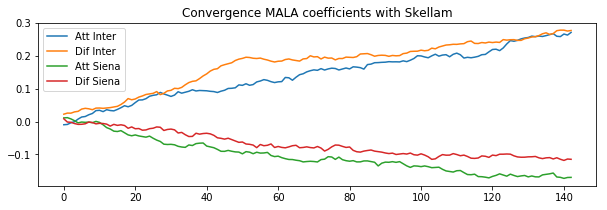

In [38]:
#Plot the evolution of Attacking and difensive Coefficients of Inter and Siena 
def vect(coef):
    
    vect_att_i=[]
    vect_def_i=[]
    vect_att_s=[]
    vect_def_s=[]
    for i in range(0,it):
        vect1=[]
        vect2=[]
        vect3=[]
        vect4=[]
        col_att = "iter"+str(i)+"att"
        col_def = "iter"+str(i)+"def"
        vect1.append(coef[col_att][8])
        vect2.append(coef[col_def][8])
        vect3.append(coef[col_att][18])
        vect4.append(coef[col_def][18])
        vect_att_i.append(vect1)
        vect_def_i.append(vect2)
        vect_att_s.append(vect3)
        vect_def_s.append(vect4)
    plt.figure(figsize=(10,3))
    plt.plot(vect_att_i, label='Att Inter')
    plt.plot(vect_def_i,label='Dif Inter')
    plt.plot(vect_att_s, label='Att Siena')
    plt.plot(vect_def_s,label='Dif Siena')
    plt.legend(loc='upper left')
    plt.title('Convergence MALA coefficients with Skellam')
    plt.savefig('MALA_Skellam.png')
    plt.show()
    return 
vect(Coef_club)


In [30]:
Coef_club

,Att,Dif,Sum_Att,Sum_Dif,i1,i2,New_Att,New_Dif,iter0att,iter0def,...,iter3att,iter3def,iter4att,iter4def,iter5att,iter5def,iter6att,iter6def,iter7att,iter7def
Team,,,,,,,,,,,,,,,,,,,,,
Atalanta,-0.001435,-0.004281,-0.016812,-0.079688,-0.076237,-0.056049,-0.076237,-0.056049,0.022137,-0.056267,...,0.022743,-0.096860,-0.013359,-0.095067,-0.039639,-0.099201,-0.055922,-0.038016,-0.076237,-0.056049
Bari,-0.009771,0.000635,0.012100,-0.003204,0.011323,-0.002403,0.011323,-0.002403,-0.003252,0.005426,...,0.018136,-0.005810,0.023187,-0.006268,0.013935,-0.004439,0.022055,-0.002766,0.011323,-0.002403
Bologna,0.008731,0.008397,-0.009588,0.000868,-0.014648,-0.001344,-0.014648,-0.001344,0.009040,0.011961,...,-0.021378,-0.003330,-0.020573,0.003209,-0.013956,-0.004490,-0.019075,-0.008575,-0.014648,-0.001344
Cagliari,-0.003481,-0.003287,-0.013448,0.004575,-0.013399,-0.002480,-0.013399,-0.002480,-0.007781,0.001326,...,-0.026395,0.009612,-0.011000,0.010370,-0.005918,0.006658,-0.011625,-0.002756,-0.013399,-0.002480
Catania,0.013003,-0.021033,0.022706,-0.035858,0.034225,-0.041662,0.034225,-0.041662,0.018515,-0.033377,...,0.018097,-0.023083,0.025693,-0.033596,0.022179,-0.032214,0.023272,-0.042918,0.034225,-0.041662
Chievo,-0.004078,-0.010901,-0.019960,-0.032319,-0.021348,-0.041580,-0.021348,-0.041580,-0.009363,-0.015365,...,-0.016633,-0.035552,-0.025959,-0.036148,-0.033580,-0.039630,-0.026328,-0.036111,-0.021348,-0.041580
Fiorentina,-0.023204,-0.010073,-0.002301,-0.000668,0.013852,0.008512,0.013852,0.008512,-0.014937,0.001066,...,0.003223,0.002537,-0.002166,-0.000105,0.006306,0.001679,0.002800,0.001283,0.013852,0.008512
Genoa,-0.008123,-0.000862,-0.000323,-0.008029,0.014578,-0.016090,0.014578,-0.016090,-0.001223,-0.005569,...,-0.001486,-0.005362,-0.011246,-0.011143,-0.005610,-0.009748,0.002749,-0.014435,0.014578,-0.016090
Inter,-0.017743,0.022230,-0.006296,0.032857,0.006329,0.033646,0.006329,0.033646,-0.003173,0.020884,...,-0.014185,0.034376,-0.007034,0.030558,-0.003447,0.033677,0.006187,0.031379,0.006329,0.033646
